In [6]:
from Bio import SeqIO
import torch
import numpy as np
from collections import OrderedDict
import torch.nn.functional as F
torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import os
import pickle
import re
import seaborn as sns
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: " + device)

Device: cuda


In [22]:
# For plotting latent space
def plot_latent(autoencoder, data, labels, cmap, phyla):
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        df = pd.DataFrame(z, columns=['z1', 'z2'])
        df['Species'] = labels
        
        sns.scatterplot(data = df, x='z1', y='z2', hue='Species', hue_order = phyla, \
                        linewidth = 0, alpha = 0.2, palette = cmap)
        xmax = max(-min(df['z1']), max(df['z1']))
        xmax += xmax / 10
        ymax = max(-min(df['z2']), max(df['z2']))
        ymax += ymax / 10
        plt.xlim(-xmax, xmax)
        plt.ylim(-ymax, ymax)


In [8]:
# Stuff to turn fasta files to sequences with numbered amino acids

IUPAC_IDX_AMINO_PAIRS = list(enumerate(["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", \
                                        "Q", "R", "S", "T", "V", "W", "X", "Y", "Z", "<mask>", "B"]))

IUPAC_AMINO_IDX_PAIRS = [(a, i) for (i, a) in IUPAC_IDX_AMINO_PAIRS]
IUPAC_SEQ2IDX = OrderedDict(IUPAC_AMINO_IDX_PAIRS)
IUPAC_SEQ2IDX["-"] = IUPAC_SEQ2IDX["<mask>"]
IUPAC_SEQ2IDX["."] = IUPAC_SEQ2IDX["<mask>"]
# print(IUPAC_SEQ2IDX)

def seq2idx(seq, device = None):
    return torch.tensor([IUPAC_SEQ2IDX[s.upper() if len(s) < 2 else s] for s in seq], device = device)

def get_labels(seq):
    pattern = re.compile("\[?([a-zA-Z]+)\]?")
    all_labels = [s.description.split(' ')[1] for s in seq]
    all_labels = [pattern.sub(r"\1", label) for label in all_labels]
    return np.array(all_labels)

In [9]:
path_to_blat = './data/beta_lactamase/alignments/BLAT_ECOLX_1_b0.5_labeled.fasta'
seqs = list(SeqIO.parse(path_to_blat, "fasta"))
encoded_seqs = torch.stack([seq2idx(seq, device) for seq in seqs])
one_hot = F.one_hot(encoded_seqs, num_classes=max(IUPAC_SEQ2IDX.values())+1).float()
labels = get_labels(seqs)
phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']
mask = [l in phyla for l in labels]

labels = labels[mask]
one_hot = one_hot[mask]

In [10]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, input_dim):
        super(VariationalEncoder, self).__init__()
        self.linear1_1 = nn.Linear(input_dim, 1500)
        self.linear1_2 = nn.Linear(1500, 1500)
        self.linear2 = nn.Linear(1500, latent_dims)
        self.linear3 = nn.Linear(1500, latent_dims)
        
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1_1(x))
        x = F.relu(self.linear1_2(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        distr = torch.distributions.Normal(mu, sigma)
        z = distr.rsample()
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dims, output_dim):
        super(Decoder, self).__init__()
        self.linear1_1 = nn.Linear(latent_dims, 100)
        self.linear1_2 = nn.Linear(100, 2000)
        self.linear2 = nn.Linear(2000, output_dim)
        
    def forward(self, z):
        z = F.relu(self.linear1_1(z))
        z = F.relu(self.linear1_2(z))
        z = self.linear2(z)
        return z
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dim, num_classes):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, input_dim)
        self.decoder = Decoder(latent_dims, input_dim)
        self.num_classes = num_classes
    
    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder(z)
        z = z.reshape(z.shape[0], z.shape[1] // self.num_classes, self.num_classes)
        return z

    
def train(autoencoder, data, epochs = 20, lr = 1e-5):
    opt = torch.optim.Adam(autoencoder.parameters(), lr = lr)
    for epoch in range(epochs):
        print("Epoch [" + str(epoch + 1) + '/' + str(num_epochs) + ']')
        batch_losses = torch.empty(len(data))
        for i, x in enumerate(data):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            
            loss_function = nn.CrossEntropyLoss(reduction = 'none')
            loss = loss_function(x_hat.transpose(1, 2), x.argmax(-1)) # Categorical loss
            loss = torch.mean(torch.sum(loss, dim = -1))
            loss += autoencoder.encoder.kl # Add KL-divergence
            
            loss.backward()
            opt.step()
            
            batch_losses[i] = loss.item()
            
        print("Last batch: " + str(loss.item()))
        print("Batch average: " + str(torch.mean(batch_losses)))
            
    return autoencoder, opt, epoch

In [ ]:
latent_dims = 2
num_epochs = 1000
lr = 1e-5

data = torch.utils.data.DataLoader(one_hot, batch_size = 2**2, shuffle = True)
num_classes = max(IUPAC_SEQ2IDX.values())+1

vae = VariationalAutoencoder(latent_dims, one_hot.shape[1] * one_hot.shape[2], num_classes).to(device) # GPU
vae, opt, epoch = train(vae, data, epochs = num_epochs, lr = lr)

Epoch [1/1000]
Last batch: 579.63525390625
Batch average: tensor(520.7590)
Epoch [2/1000]
Last batch: 95.7995376586914
Batch average: tensor(417.9144)
Epoch [3/1000]
Last batch: 367.848876953125
Batch average: tensor(389.4355)
Epoch [4/1000]
Last batch: 363.9201354980469
Batch average: tensor(375.0401)
Epoch [5/1000]
Last batch: 549.1304931640625
Batch average: tensor(363.8191)
Epoch [6/1000]
Last batch: 275.1297912597656
Batch average: tensor(356.0921)
Epoch [7/1000]
Last batch: 47.969730377197266
Batch average: tensor(350.8775)
Epoch [8/1000]
Last batch: 496.6482849121094
Batch average: tensor(346.7975)
Epoch [9/1000]
Last batch: 384.2179260253906
Batch average: tensor(343.0645)
Epoch [10/1000]
Last batch: 345.2604064941406
Batch average: tensor(339.9818)
Epoch [11/1000]
Last batch: 45.9276237487793
Batch average: tensor(336.8823)
Epoch [12/1000]
Last batch: 357.3685302734375
Batch average: tensor(334.3350)
Epoch [13/1000]
Last batch: 423.9717712402344
Batch average: tensor(331.6176)

Last batch: 295.8028869628906
Batch average: tensor(269.0629)
Epoch [107/1000]
Last batch: 388.1938171386719
Batch average: tensor(268.7980)
Epoch [108/1000]
Last batch: 27.222640991210938
Batch average: tensor(268.2820)
Epoch [109/1000]
Last batch: 248.74485778808594
Batch average: tensor(268.1743)
Epoch [110/1000]
Last batch: 294.73626708984375
Batch average: tensor(267.9463)
Epoch [111/1000]
Last batch: 437.6778869628906
Batch average: tensor(267.6469)
Epoch [112/1000]
Last batch: 55.606929779052734
Batch average: tensor(267.1423)
Epoch [113/1000]
Last batch: 26.688804626464844
Batch average: tensor(267.0196)
Epoch [114/1000]
Last batch: 277.738037109375
Batch average: tensor(266.6679)
Epoch [115/1000]
Last batch: 448.23419189453125
Batch average: tensor(266.5594)
Epoch [116/1000]
Last batch: 182.63003540039062
Batch average: tensor(266.1858)
Epoch [117/1000]
Last batch: 35.33480453491211
Batch average: tensor(265.7941)
Epoch [118/1000]
Last batch: 182.06448364257812
Batch average: 

Last batch: 251.97752380371094
Batch average: tensor(248.7499)
Epoch [211/1000]
Last batch: 23.234905242919922
Batch average: tensor(248.6050)
Epoch [212/1000]
Last batch: 241.27149963378906
Batch average: tensor(248.4786)
Epoch [213/1000]
Last batch: 320.56201171875
Batch average: tensor(248.4453)
Epoch [214/1000]
Last batch: 191.04905700683594
Batch average: tensor(248.1540)
Epoch [215/1000]
Last batch: 260.3931579589844
Batch average: tensor(248.2546)
Epoch [216/1000]
Last batch: 20.4454345703125
Batch average: tensor(247.7985)
Epoch [217/1000]
Last batch: 125.84232330322266
Batch average: tensor(247.7906)
Epoch [218/1000]
Last batch: 311.4598388671875
Batch average: tensor(247.7970)
Epoch [219/1000]
Last batch: 301.9486389160156
Batch average: tensor(247.6147)
Epoch [220/1000]
Last batch: 369.1878662109375
Batch average: tensor(247.5041)
Epoch [221/1000]
Last batch: 248.7623291015625
Batch average: tensor(247.2910)
Epoch [222/1000]
Last batch: 131.6526336669922
Batch average: tenso

Last batch: 177.0384521484375
Batch average: tensor(237.1416)
Epoch [315/1000]
Last batch: 239.45077514648438
Batch average: tensor(237.1143)
Epoch [316/1000]
Last batch: 55.94704818725586
Batch average: tensor(236.7745)
Epoch [317/1000]
Last batch: 268.737060546875
Batch average: tensor(236.9835)
Epoch [318/1000]
Last batch: 267.8738708496094
Batch average: tensor(236.7560)
Epoch [319/1000]
Last batch: 235.1959991455078
Batch average: tensor(236.7438)
Epoch [320/1000]
Last batch: 20.396900177001953
Batch average: tensor(236.5230)
Epoch [321/1000]
Last batch: 141.3514404296875
Batch average: tensor(236.3591)
Epoch [322/1000]
Last batch: 216.8799591064453
Batch average: tensor(236.4332)
Epoch [323/1000]
Last batch: 321.324951171875
Batch average: tensor(236.4176)
Epoch [324/1000]
Last batch: 40.069366455078125
Batch average: tensor(236.0306)
Epoch [325/1000]
Last batch: 306.04315185546875
Batch average: tensor(236.0832)
Epoch [326/1000]
Last batch: 329.3475341796875
Batch average: tenso

Last batch: 455.01934814453125
Batch average: tensor(228.5059)
Epoch [419/1000]
Last batch: 215.6616668701172
Batch average: tensor(228.3219)
Epoch [420/1000]
Last batch: 28.03685188293457
Batch average: tensor(228.1398)
Epoch [421/1000]
Last batch: 137.90731811523438
Batch average: tensor(228.0906)
Epoch [422/1000]
Last batch: 207.06005859375
Batch average: tensor(227.9891)
Epoch [423/1000]
Last batch: 46.263668060302734
Batch average: tensor(227.8875)
Epoch [424/1000]
Last batch: 215.19972229003906
Batch average: tensor(227.7543)
Epoch [425/1000]
Last batch: 440.44781494140625
Batch average: tensor(227.8626)
Epoch [426/1000]
Last batch: 20.242206573486328
Batch average: tensor(227.7162)
Epoch [427/1000]
Last batch: 327.7586364746094
Batch average: tensor(227.8106)
Epoch [428/1000]
Last batch: 178.47799682617188
Batch average: tensor(227.5118)
Epoch [429/1000]
Last batch: 278.02508544921875
Batch average: tensor(227.5463)
Epoch [430/1000]
Last batch: 325.2311096191406
Batch average: t

Last batch: 210.45407104492188
Batch average: tensor(221.1642)
Epoch [523/1000]
Last batch: 265.7366027832031
Batch average: tensor(221.2153)
Epoch [524/1000]
Last batch: 249.13328552246094
Batch average: tensor(221.0767)
Epoch [525/1000]
Last batch: 109.1839599609375
Batch average: tensor(221.0732)
Epoch [526/1000]
Last batch: 391.8053894042969
Batch average: tensor(221.0217)
Epoch [527/1000]
Last batch: 139.1621856689453
Batch average: tensor(220.8791)
Epoch [528/1000]
Last batch: 50.88433837890625
Batch average: tensor(220.7611)
Epoch [529/1000]
Last batch: 191.59088134765625
Batch average: tensor(220.6924)
Epoch [530/1000]
Last batch: 158.00592041015625
Batch average: tensor(220.7916)
Epoch [531/1000]
Last batch: 231.33836364746094
Batch average: tensor(220.7533)
Epoch [532/1000]
Last batch: 300.5526123046875
Batch average: tensor(220.6910)
Epoch [533/1000]
Last batch: 173.9828338623047
Batch average: tensor(220.6305)
Epoch [534/1000]
Last batch: 249.93089294433594
Batch average: t

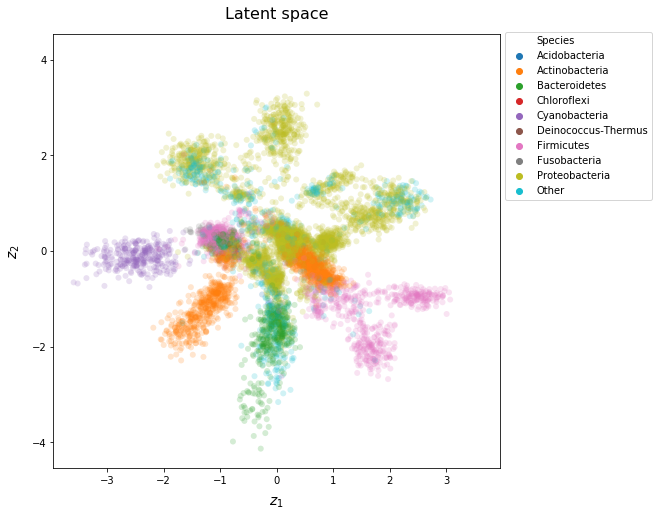

In [25]:
plt.figure(figsize=(8,8))
plot_data = torch.utils.data.DataLoader(one_hot, batch_size = len(one_hot), shuffle = False)
cmap = 'tab10'
z = plot_latent(vae, plot_data, labels, cmap, phyla)
plt.title("Latent space", fontsize = 16, y = 1.02)
plt.xlabel(r'$z_1$', labelpad = 10, size = 14)
plt.ylabel(r'$z_2$', labelpad = 10, size = 14)
plt.legend(bbox_to_anchor=(1,1.015))
plt.show()

In [38]:
# Save model
# check = input("Remembered to change model dict name? [y/*] ")
check = 'y'
today = str(date.today()).replace("-", "")
save_file = './Models/model_dict_'+ today +'_VAE_DeepSequenceBase_%iepochs.tar' %(epoch + 1)

if check == 'y':
    torch.save({'epoch': epoch,
                'model_state_dict': vae.state_dict(),
                'optimizer_state_dict': opt.state_dict()}, \
                save_file)
    print("Saved at " + os.getcwd() + save_file)
else:
    print("Change model dict name")

Saved at ./home/hdm692/VAE/Models/model_dict_20211001_VAE_DeepSequenceBase_1000epochs.tar
